# Exceptional Preference Mining (EPM) using Preference Matrix

Author : Charles Gaydon

February 2018

Context : I wanted to discover this interesting aspect of Data Science that is EPM.

Note : This notebook is structured as a draft. It shows, step by step, how I implemented te beam search algorithm using toy data and toy score function, then implemented an EP score function, and finally applied it to the sushi dataset.

**CONTENT** :  
- **Subgroup Discovery** using a **beam search** (see more [here](http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume17/gamberger02a-html/node4.html))

- **Subgroup selection** using a score of "Exceptional Preference", based on a **Preference Matrix** (PM) obtained from the ranking of some items. This idea is proposed by Claudio Rebelo de Sa *et al* in their article [Exceptional Preference Mining](https://biblio.ugent.be/publication/8519644/file/8519856.pdf)

- The whole method is applied to the [**Sushi preference dataset**](http://www.kamishima.net/sushi/), set A, in which 10 sushis were ranked by 5000 subjects, about whom we possess some information.

In [1]:
# imports
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as mc

Playing with toy data, we first developp the beam search algorithm with a naive score for a subgroup : the mean sd of each object's rank, which is the sd of the matrix of ranks. 
We will change this to a more meaningful score (see the end of the notebook).

In [2]:
Usource = "toydata/Udata.tsv"
Uranks = "toydata/Uranks3.tsv"
Udata = pd.read_csv(Usource, sep = "\t", dtype=str)
Udata.head(5)

,attr1,attr2
0,1,A
1,1,B
2,1,B
3,1,A
4,1,A


In [3]:
Rdata = pd.read_csv(Uranks, sep = "\t", header=None, names = ["obj"+str(i) for i in [1,2,3]]) #col 1 == obj 1 !!!
Rdata.head(5)

,obj1,obj2,obj3
0,1,3,2
1,1,2,3
2,2,3,1
3,3,1,2
4,1,3,2


**Important** :

Data from this point on are considered clean in order to be fed to the Beam Search algorithm :
- no missing value in a row ;
- a column j in Rdata corresponds to the jth object of the set considered ;
- the ith value of the column is the rank of this object attributed by the ith subject of the Udata.
- subjects are described by attributes, which were binned into a finite set of values (2 in our toy data).

Beam Search ALGORITHIM

In [4]:
# a condition is defined by an attribute which may take a value. ex : sexe = 1
class condition:
    
    def __init__(self, first_attr, value_taken, relation):
        self.attr_name = first_attr
        self.takes_value = value_taken
        self.relation = relation

    def __str__(self):
        return("[" + self.attr_name + " " + self.relation + " " + self.takes_value+"]")

# a rule is a set of conditions
class rule:
    
    def __init__(self, first_attr= None, first_value = None, first_relation = None, start_condition = None, start_rule = None):
        self.score = 0.0
        self.conds = []
        if start_condition != None:
            self.add(start_condition)
        elif first_attr != None and first_value!=None and first_relation!=None :
            self.add(condition(first_attr, first_value, first_relation))
        elif start_rule != None : 
            self.score = start_rule.score
            self.conds = deepcopy(start_rule.conds)
    
    # add a condition to the rule, ony if attr was not yet present
    def add(self, new_cond): 
        if new_cond.attr_name in [c.attr_name for c in self.conds]:
            return(0)
        self.conds.append(new_cond)
        return(1)
    
    # generate the subset of ranking data from the two dataframes
    def get_subset(self, Udata, Rdata):
        attr_names = Rdata.columns
        all_data = pd.concat([Udata,Rdata],axis=1)
        for cond in self.conds:
            if cond.relation == "=":
                all_data = all_data[all_data[cond.attr_name] == cond.takes_value]
            elif cond.relation == "<":
                all_data = all_data[all_data[cond.attr_name] < cond.takes_value]
            elif cond.relation == ">":
                all_data = all_data[all_data[cond.attr_name] > cond.takes_value]
                
        return(all_data[attr_names].values)  
    
    # for equal string representation.
    def reorder_conds(self):
        #TODO
        pass
    
    def __str__(self):
        out = [cond.__str__() for cond in self.conds]
        return(" & ".join(out))
    
# set in ascending order a list of rules based on their score
def reorder(rules):
    return(sorted(rules, key = lambda x : x.score))

# a naive default score function for the subset discovery, for dev purpose
def naive_score_function(ranks):
    return(np.std(ranks[:,0]))

# TESTS    
# cond1 = condition("attr1", "2", "<")
# cond2 = condition("attr2", "1",">")
# rule1 = rule(start_condition = cond1)
# rule1.add(cond2)
# print(rule1)

In [5]:
def beam_search(Udata, Rdata, beam_width, max_iter = 50,verbose = False, score_function = naive_score_function):
    # initialisation of the different conditions to combine
    L = []
    for attr in Udata.columns : 
        uniques = np.unique(Udata[attr].values)
        for index,val in enumerate(uniques) :
            L.append(condition(attr, val, "="))
            # inf and sup cond without redundancy with equality
            if index >1 and index<(len(uniques)-2):
                L.append(condition(attr, val, "<"))
                L.append(condition(attr, val, ">"))
            
    # Initialization of the beam lists
    beam = []
    new_beam = []
    for c in range(beam_width):
        beam.append(rule())
        new_beam.append(rule())
    i = 0
    while i < max_iter:
        for r in beam : 
            # shuffling the rules for better generation. 
            # Note : this is an inplace operation.
            np.random.shuffle(L)
            for l in L:
                
                new_r = rule(start_rule = r)
                
                # exit if condition was already there
                is_actually_new = new_r.add(l)              
                if not is_actually_new:
                    break 
                    
                # exit if rule was already found
                is_not_yet_in_new_beam = (new_r.__str__() not in [b.__str__() for b in new_beam])
                if not is_not_yet_in_new_beam:
                    break
                    
                # generate subset and compute score    
                Rsubset = new_r.get_subset(Udata, Rdata)
                new_score = score_function(Rsubset)
                
                if verbose:
                    print(new_r.__str__(), "->",round(new_score,2))
                
                # update new beam if new score is better than the worst of new beam
                if new_score > new_beam[0].score:
                    new_r.score = new_score
                    new_beam[0] = new_r
                    new_beam = reorder(new_beam)
                    if verbose:
                        print("new beam =", [b.__str__() for b in new_beam])
                        
        # stop the search if no difference was made in this iteration
        if [b.__str__() for b in new_beam] == [b.__str__() for b in beam]:
            print("["+str(i)+"] BEAM =", [b.__str__() for b in beam])
            break
            
        # update the beam
        beam = deepcopy(new_beam)
        
        if verbose:
            print("["+str(i)+"] BEAM =", [b.__str__() for b in beam])
            print("-----------------------------------------")
            
        i+=1
    if not verbose :
        print("["+str(i)+"] BEAM =", [b.__str__() for b in beam])
        print("-----------------------------------------")
    return(beam, [b.__str__() for b in beam])
# TEST
# b, b_str = beam_search(Udata, Rdata, 2, verbose= False)
# print(b[-1].get_subset(Udata,Rdata))

Now let us use our sushi data set, and find exceptionnal groups based on certain simple attribute i.e. that can be transformed in a meaningful manner in a categorical attribute (or already are categorical)

In [6]:
Usource = "sushi3-2016/sushi3.udata"
Uranks = "sushi3-2016/sushi3a.5000.10.order"

# SUSHI : USER DATA
Udata = pd.read_csv(Usource, sep = "\t", header=None, names = ["ID", 
                                                                          "gender",
                                                                          "age",
                                                                          "time",
                                                                          "prefID",
                                                                          "regID",
                                                                          "EWID",
                                                                          "curprefID",
                                                                          "curregID",
                                                                          "curEWID",
                                                                          "eqprefs"])
# speed to fill the form 0 : slow, 1 : medium ,2 : fast
Udata["velocity"], bins = pd.qcut(Udata["time"].values,3,
                                  labels = False,
                                  retbins=True) 
# print("Speed limits for the three levels : "+ str(bins) + ' (secs)')
# dropping some data for computational efficiency of the Beam Search algo
Udata = Udata.drop(["ID","prefID","regID","curprefID","curregID","curEWID","time"],axis=1)
Udata = pd.DataFrame(Udata,dtype=str)
# because this is an assumption of the Beam Search algorithm above !
Udata.head(5)

,gender,age,EWID,eqprefs,velocity
0,0,2,0,0,2
1,1,1,1,0,0
2,1,2,1,1,2
3,0,4,1,1,2
4,1,1,1,1,2


In [7]:
#SUSHI : RANKING DATA
sushis = ["ebi","anago","maguro","ika","uni","ikura","tamago","toro","tekka_maki","kappa_maki"]
Rdata = pd.read_csv(Uranks, sep = " ", header=None,skiprows=1, names = ["X0","X10"]+sushis)
Rdata = Rdata.drop(["X0", "X10"],axis=1)  
Rdata.head()

,ebi,anago,maguro,ika,uni,ikura,tamago,toro,tekka_maki,kappa_maki
0,5,0,3,4,6,9,8,1,7,2
1,0,9,6,3,7,2,8,1,5,4
2,7,0,2,3,8,4,5,1,9,6
3,4,5,7,0,2,3,1,6,8,9
4,8,6,5,0,3,9,2,7,4,1


For a use in the notebook "Example worflow", we save those preprocessed data.

In [8]:
Udata.to_csv(path_or_buf = "sushi3-2016/forEPM.sushi3.udata", sep= " ", index = False)
Rdata.to_csv(path_or_buf = "sushi3-2016/forEPM.sushi3a.5000.10.order", sep= " ", index = False)

Here in the first colums is the id of the prefered sushi, and in the last is the idea of the less appreciated sushi...

We want to change this so that the first columns is the rank given to the sushi of id 1, etc...

In [9]:
# our ranks go from 1 to 10 for a normal human interpretation 
def transform_ranks(x):
    y = np.zeros_like(x)
    for rank, ID in enumerate(x):
        y[ID] = rank+1
    return(y)

# TEST :
# transform_ranks(Rdata.iloc[0].values)
Rdata = Rdata.apply(transform_ranks,axis=1)

Now let us define our Exceptional Preference score. It is based on the article [*Exceptional Preference Mining*](https://biblio.ugent.be/publication/8519644/file/8519856.pdf) by Claudio Rebelo de Sa *et al*

In [10]:
# we compute a preference matrix (PM) that gives the relative pairwise preferences for an item/sushi

"""
ranks : a numpy array, 
"""
def fill_PM_with_row(PM, row, l, w):
    """ Fill a preference matrix (PM)
    Input : 
        - PM : is a (w,w) (w = nb of items ranked) numpy array filled of zeros 
        - row : the rankings of a subject to take into account
        - l, w : length and w of the dataset at end. l is useless here anc could be removed.
    """
    for i in np.arange(w):
        for j in np.arange(w):
#                 print(i,j, row, PM.shape)
            PM[i,j]+=np.sign(row[i]-row[j])
    return(PM)
    
def compute_PM(ranks):
    l,w = ranks.shape
#     print(l,w)
    if l==0:
        return(None)
    PM = np.zeros((w,w))
    np.apply_along_axis(lambda row : fill_PM_with_row(PM, row, l, w),1, ranks)
    PM/= float(l)
    return(PM)

# N : size of the origina dataset
def compute_PM_score(ranks,globalPM, N, method = "Norm"):
    PM = compute_PM(ranks)
    
    #if subgroup is empty, return score=0
    if PM is None :
            return(0.0)
        
    if method == "Norm":
        # Frobenius norm of the difference
        criteria = np.linalg.norm(PM-globalPM,ord='fro')
    else:
        pass
    # weighted by sqrt(size of the subgroup)
    return(criteria*np.sqrt(ranks.shape[0]/float(N)))
    

# To visualise the preference matrix in a nice way
def display_PM(PM, items_names):
    fig = plt.figure()
    # PREFERENCE MATRIX
    ax = fig.add_subplot(1,1,1)
    cax = ax.matshow(PM, cmap='seismic')
#     fig.colorbar(cax)
    # Axes
    ax.set_xticklabels([''] + items_names, rotation=90)
    ax.set_yticklabels([''] + items_names)
    
#     .title()
    # Label pour chaque index
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    # BARPLOT OF PREFERENCES
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    w = PM.sum(axis=1)
    norm01 = mc.Normalize(vmin=min(w),vmax=max(w))
    plt.barh(list(range(10)),w, tick_label = items_names,color = cm.seismic(norm01(w)))
    plt.title("Barplot of preferences")
    plt.show()
    
def display_best_PM(beam, Udata, Rdata, items_names, n=1, relative = False):
    assert n<=len(beam)
    for i in np.arange(n):
        print("PM #"+str(i)+" is obtained with rule : ")
        rule = beam[-(i+1)]
        print(rule.__str__() + " and score :" + str(rule.score))
        ranks = rule.get_subset(Udata,Rdata)
        PM = compute_PM(ranks)
        if relative:
            print("PM differences are as follow :")
            final = (1.0/2)*(compute_PM(Rdata.values)-PM)
            display_PM(final,items_names)
            #(division by 2 limits the distance to the interval [1; 1]
        else:
            print("PM is :")
            final = PM
            display_PM(final,items_names)
    
# TEST
# compute_PM(np.random.randint(0,high=10,size=(10,4)))

First we compute the PM on the whole dataset

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs


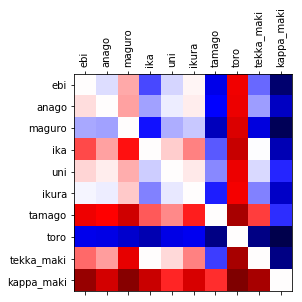

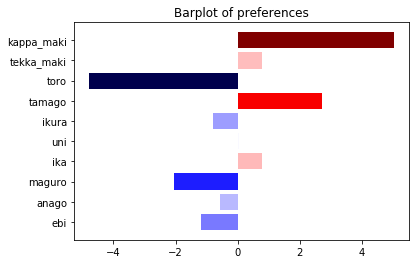

In [11]:
%time #really fast !
PM_5000 = compute_PM(Rdata.values)
display_PM(PM_5000, Rdata.columns.tolist()) 

Interpretation is easy. For instance, toro is globaly less appreciated than the other sushis, maguro as well to a certain extend. And tamago and kappa makis are loved by everyone... with this relationship : kappa_maki > tamago.

This is clearly seen when we compute the sum over a row :)

The PM of the subgroup is compared to the PM of the whole dataset. This gives an **exceptionality score**.

Here, we build a particular function to avoid computing the PM for the whole dataset at each step.

In [12]:
get_PM_score = lambda ranks : compute_PM_score(ranks, PM_5000, Rdata.shape[1],method = "Norm")

Let us now apply our previous Beam Search algorithm

In [13]:
b, b_str = beam_search(Udata, Rdata, 5, max_iter = 50,verbose = True, score_function = get_PM_score)

[age = 4] -> 7.57
new beam = ['', '', '', '', '[age = 4]']
[gender = 1] -> 10.24
new beam = ['', '', '', '[age = 4]', '[gender = 1]']
[age < 3] -> 6.65
new beam = ['', '', '[age < 3]', '[age = 4]', '[gender = 1]']
[velocity = 2] -> 3.66
new beam = ['', '[velocity = 2]', '[age < 3]', '[age = 4]', '[gender = 1]']
[eqprefs = 0] -> 4.18
new beam = ['[velocity = 2]', '[eqprefs = 0]', '[age < 3]', '[age = 4]', '[gender = 1]']
[velocity = 0] -> 3.98
new beam = ['[velocity = 0]', '[eqprefs = 0]', '[age < 3]', '[age = 4]', '[gender = 1]']
[age > 2] -> 10.88
new beam = ['[eqprefs = 0]', '[age < 3]', '[age = 4]', '[gender = 1]', '[age > 2]']
[age = 2] -> 4.19
new beam = ['[age = 2]', '[age < 3]', '[age = 4]', '[gender = 1]', '[age > 2]']
[age = 0] -> 11.28
new beam = ['[age < 3]', '[age = 4]', '[gender = 1]', '[age > 2]', '[age = 0]']
[age < 2] -> 10.8
new beam = ['[age = 4]', '[gender = 1]', '[age < 2]', '[age > 2]', '[age = 0]']
[EWID = 1] -> 6.9
[age > 3] -> 9.29
new beam = ['[age > 3]', '[gen

Here are the most important rules found, as well as the PM associated.

PM #0 is obtained with rule : 
[age > 2] & [gender = 0] and score :11.5590982836
PM differences are as follow :


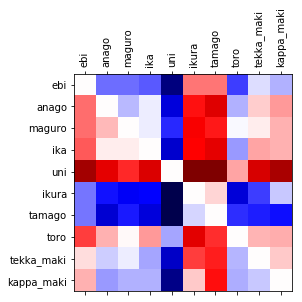

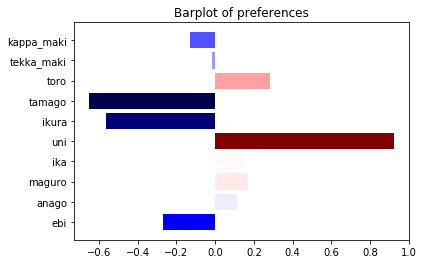

PM #1 is obtained with rule : 
[gender = 1] & [age < 3] and score :11.5262741814
PM differences are as follow :


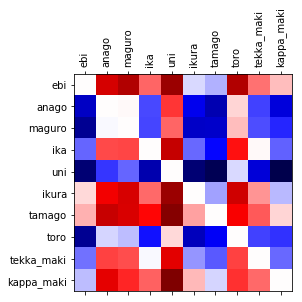

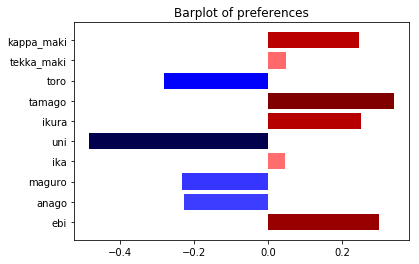

PM #2 is obtained with rule : 
[age = 0] and score :11.2789842596
PM differences are as follow :


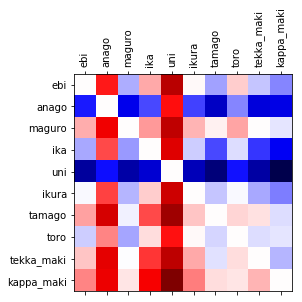

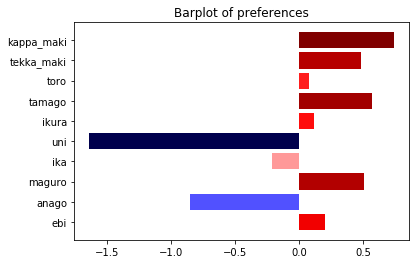

PM #3 is obtained with rule : 
[age = 0] & [gender = 1] and score :11.2690663863
PM differences are as follow :


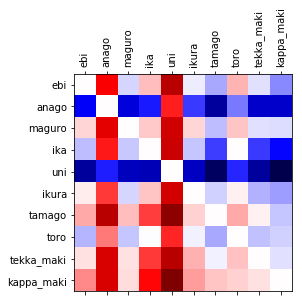

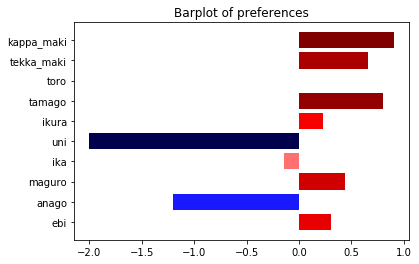

In [14]:
display_best_PM(b, Udata, Rdata, sushis, n=4, relative = True)

So we can immediatly see some interestings results here  :

- the youngest (age=0 : below 19 years old)  are globally less attracted to uni and anago sushis compared to their elders; 
- people below 29 years old (age < 2) follow the same trend but with less intensity ; the bigger size of the subgroup explains why it was nevertheless kept in the results;
- being old is associated with a net disdain for ikura and tamaro compared to the rest of the population, as well as for ebi sushis ;
- compared to the rest of the population (so to females), males (gender=0) have quite different tastes. The subgroups should be studied separately.

## Conclusion

**Credit** : this work was inspired by this [repository](https://github.com/alicemontel/M2DS_MusicProject) in which the previous EPM algorithm is naively implemented.

Our contribution is the implementation of the Beam Search algorithm, as well as an improved computational efficiency in the computation of the PM using numpy matrix operations. 

Furthermore, this notebook explain a reproductible demarch to mine exceptionnal preference pattern in virtually any ranking dataset.

Over the 24/02/2018